<a href="https://colab.research.google.com/github/jcandane/SSA/blob/main/JAX_LOBPCG_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA on the Cloud

# Lets do our imports of stuff we may need

In [1]:
### our GPU array library
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental.sparse.linalg import lobpcg_standard as LOBPCG
key = jax.random.PRNGKey(187)

### our CPU array library
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from scipy.linalg import orthogonal_procrustes
from numpy import sum as Σ

### method to compare to
from sklearn.decomposition import PCA

### our dataset
try:
    from gym_rings import get_rings
except:
    !wget https://raw.githubusercontent.com/jcandane/gym_rings/main/gym_rings.py
    from gym_rings import get_rings
### our Cloud Computing Service
try:
    import modal ##?
except:
    !pip install -q modal
    import modal

## Let's examine our data set

(360, 128, 128) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


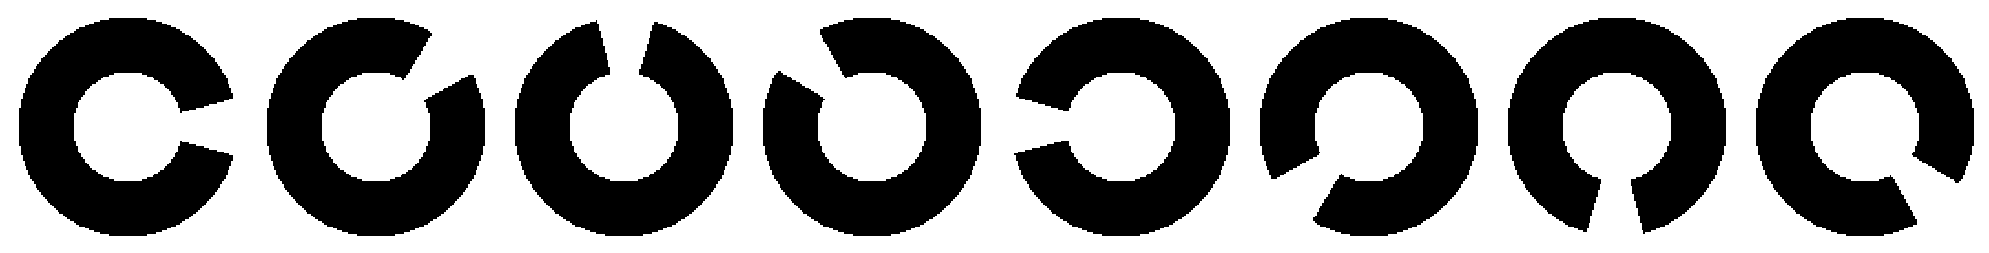

In [47]:
θs    = np.arange(0,360,1).reshape(-1,1).T
R_ixy = get_rings(128, θs, jnp.array([[30,60]]), notch_width=15.)
R_iz  = R_ixy.reshape(θs.size,-1)
R_iX  = 1.*(R_iz)

print( R_ixy.shape, type(R_ixy), type(R_iX) )

# Create 8 subplots in one row
plots = 8
θ = np.linspace(0, len(R_iX)-1, plots+1, dtype=int)[:plots]
fig, axes = plt.subplots(1, 8, figsize=(20, 3))  # Adjust figsize as needed
for i, ax in enumerate(axes):
    im = ax.imshow(R_ixy[θ[i]], interpolation='none', cmap='Greys')
    ax.axis('off')  # Hide axes for a cleaner look
plt.tight_layout()
plt.show()

## Scikit-Learn Approch

In [19]:
pca   = PCA(n_components=2)
X_pca = pca.fit_transform(R_iX)

## NumPy+SciPy Approch

In [52]:
N = R_iX.shape[0]

mean     = np.mean(R_iX, axis=0)
cen_R_iy = R_iX - mean

def mv(v):
    return cen_R_iy.T @ (cen_R_iy @ v) / (N-1)
A         = LinearOperator((R_iX.shape[1],R_iX.shape[1]), matvec=mv)
S_i, R_yx = scipy.sparse.linalg.eigsh(A, k=2)

idx  = np.argsort(S_i)[::-1]  # descending order
S_i  = S_i[idx]
R_yx = R_yx[:, idx]
R_ix = cen_R_iy @ R_yx

## JAX Approch

we use [`LOBPCG`](https://docs.jax.dev/en/latest/_autosummary/jax.experimental.sparse.linalg.lobpcg_standard.html)

In [53]:
def PCA_LO(R: jax.Array, k: int):
    N, D = R.shape

    # Step 1: Center the data (column-wise)
    mean = jnp.mean(R, axis=0, keepdims=True)
    R_centered = R - mean

    # Step 2: Define covariance matrix multiplication operator
    def LO(v):  # v: shape (D, k)
        return (R_centered.T @ (R_centered @ v)) / (N-1)

    # Step 3: Initial guess (random orthonormal matrix)
    key     = jax.random.PRNGKey(0)
    init    = jax.random.normal(key, (D, k))
    init, _ = jnp.linalg.qr(init)  # Orthonormalize

    # Step 4: Run LOBPCG
    result  = LOBPCG(LO, init)
    eigvals = result[0]
    eigvecs = result[1] #.eigenvectors

    # Step 5: Sort eigenvectors by descending eigenvalue
    idx      = jnp.argsort(-eigvals)
    loadings = eigvecs[:, idx[:k]]  # shape (D, k)

    # Step 6: Compute latents (project data onto loadings)
    latents = R_centered @ loadings  # shape (N, k)

    # Step 7: Return results
    return latents, loadings, mean.squeeze()

In [54]:
J_iX = jnp.array(R_iX) ### <<--- put R_iX on the GPU, lets call this differently

J_ix, U_xX, μ_X = PCA_LO(J_iX, k=2)
Z_ix            = J_ix @ U_xX.T + μ_X ### reconstructions

J_ix.shape, Z_ix.shape

((360, 2), (360, 16384))

## Compare Scikit-Learn, NumPy+SciPy, JAX:

Npy Max absolute error: 0.0007836264060232523
Npy Mean squared error: 1.6594640002593977e-07
JAX Max absolute error: 0.0007836267477063785
JAX Mean squared error: 1.659463936988992e-07
float64 float64 <class 'jaxlib.xla_extension.ArrayImpl'>


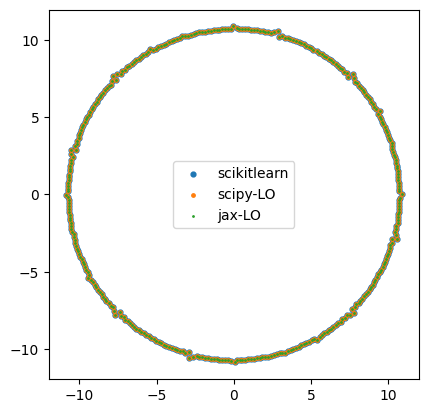

In [55]:
# Find optimal rotation (and scaling) to align your PCA with scikit-learn's
R, scale = orthogonal_procrustes(R_ix, X_pca)
R_ix_aligned = R_ix @ R  # shape (360, 2)

# Now compare
error = X_pca - R_ix_aligned
print("Npy Max absolute error:", np.max(np.abs(error)))
print("Npy Mean squared error:", np.mean(error**2))

# Find optimal rotation (and scaling) to align your PCA with scikit-learn's
R, scale     = orthogonal_procrustes(J_ix, X_pca)
J_ix_aligned = J_ix @ R  # shape (360, 2) # Apply the transformation to your custom PCA

# Now compare
error = X_pca - J_ix_aligned
print("JAX Max absolute error:", np.max(np.abs(error)))
print("JAX Mean squared error:", np.mean(error**2))


print(X_pca.dtype, J_ix.dtype, type(J_ix_aligned))
plt.scatter(X_pca[:,0], X_pca[:,1], s=12, label="scikitlearn")
plt.scatter(R_ix_aligned[:,0], R_ix_aligned[:,1], s=6, label="scipy-LO")
plt.scatter(J_ix_aligned[:,0], J_ix_aligned[:,1], s=1, label="jax-LO")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

# now on the Modal cloud

### inorder to send a ephermal app to Modal, we start by creating a folder/repo to send. lets call this directory `pca`

In [7]:
!mkdir -p pca

### Great now that we have the directory, we can use colab magic to create a python file with our core algorithm lets call this `pca_gpu.py`

In [8]:
%%writefile pca/pca_gpu.py

import jax
import jax.numpy as jnp
from jax.experimental.sparse.linalg import lobpcg_standard as LOBPCG

def PCA_LO(R: jax.Array, k: int):
    N, D = R.shape

    # Step 1: Center the data (column-wise)
    mean = jnp.mean(R, axis=0, keepdims=True)
    R_centered = R - mean

    # Step 2: Define covariance matrix multiplication operator
    def LO(v):  # v: shape (D, k)
        return (R_centered.T @ (R_centered @ v)) / (N-1)

    # Step 3: Initial guess (random orthonormal matrix)
    key     = jax.random.PRNGKey(0)
    init    = jax.random.normal(key, (D, k))
    init, _ = jnp.linalg.qr(init)  # Orthonormalize

    # Step 4: Run LOBPCG
    result  = LOBPCG(LO, init)
    eigvals = result[0]
    eigvecs = result[1] #.eigenvectors

    # Step 5: Sort eigenvectors by descending eigenvalue
    idx = jnp.argsort(-eigvals)
    loadings = eigvecs[:, idx[:k]]  # shape (D, k)

    # Step 6: Compute latents (project data onto loadings)
    latents = R_centered @ loadings  # shape (N, k)

    # Step 7: Return results
    return latents, loadings, mean.squeeze()

Overwriting pca/pca_gpu.py


### Nice our core code is above in `pca_gpu.py`, but let's now design out Modal Cloud VM. This is done with another python file `modal_app.py`, placed in the same folder/repo `pca` as our core code, e.g. `pca_gpu.py`. This `modal_app.py` is written in the same Colab magic:

### Great! now we have our app ready to be deployed! but how does Modal know its us sending the job and not something else, e.g. our friend? ....
### We need to put in our credentials.

### Modal has two such credentials: `MODAL_TOKEN_ID` (it's me) and `MODAL_TOKEN_SECRET` (here's my password). These can be saved in a `.env` file if we work locally, or in Google-Colab we can save in secrets and access via `from google.colab import userdata`.

In [10]:
from google.colab import userdata

id     = userdata.get("MODAL_TOKEN_ID")
secret = userdata.get("MODAL_TOKEN_SECRET")

### Next, I designed this python function to login you into Modal, just use as is:

In [11]:
def set_modal_tokens(token_id: str, token_secret: str):
    import subprocess

    cmd = [
        "modal", "token", "set",
        "--token-id", token_id,
        "--token-secret", token_secret
    ]
    subprocess.run(cmd, check=True)
    print("✅ Tokens configured successfully.")
    return None

set_modal_tokens(id, secret)

✅ Tokens configured successfully.


### you may need to restart the notebook.

### Now logined in, repo ready, you are ready to deploy on the cloud:

In [13]:
from pca.modal_app import app, train_remote

with app.run():  # ✅ Modal container lifecycle managed here
    R_ix, U_xX, μ_X = train_remote.remote( R_iy, k=2 )

### be patient the first run it has to construct the enviroment, however this is later cached (reused), before it actually runs your code!

Max absolute error: 0.0010621236594912098
Mean squared error: 2.2330777668369518e-07
float64 float64


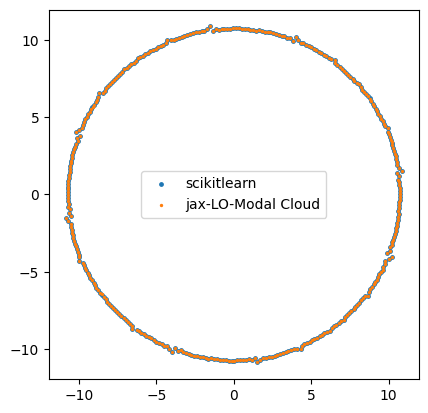

In [14]:
from scipy.linalg import orthogonal_procrustes

# Find optimal rotation (and scaling) to align your PCA with scikit-learn's
R, scale     = orthogonal_procrustes(R_ix, X_pca)
R_ix_aligned = R_ix @ R  # shape (360, 2) # Apply the transformation to your custom PCA

# Now compare
error = X_pca - R_ix_aligned
print("Max absolute error:", np.max(np.abs(error)))
print("Mean squared error:", np.mean(error**2))
print(X_pca.dtype, R_ix.dtype)

plt.scatter(X_pca[:,0], X_pca[:,1], s=6, label="scikitlearn")
plt.scatter(R_ix_aligned[:,0], R_ix_aligned[:,1], s=2, label="jax-LO-Modal Cloud")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()